In [1]:
#import required libraries
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="dark")
# plt.style.use('seaborn')

import PIL
import cv2
from sklearn.model_selection import train_test_split

from sklearn import metrics

import time
import os
import copy
import pathlib

# interactive mode
plt.ion()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from skimage import io, transform
from sklearn.preprocessing import MultiLabelBinarizer

In [3]:
# Check if GPU is available
device = 'cpu'
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = 'cuda'
    print("Using CUDA")

Using CUDA


In [4]:
# define paths
DATA_DIR = './'
TRAIN = 'data/train/'
TEST = 'data/test/'
LABELS_FILE = 'data/train.csv'
SAMPLE = 'data/sample_submission.csv'
RANDOM_SEED = 42

SHAPE = (226, 226, 3)

In [5]:
LABELS_MAP = {
    0:  'Nucleoplasm',
    1:  'Nuclear membrane',
    2:  'Nucleoli',   
    3:  'Nucleoli fibrillar center',
    4:  'Nuclear speckles',
    5:  'Nuclear bodies',
    6:  'Endoplasmic reticulum',   
    7:  'Golgi apparatus',
    8:  'Peroxisomes',
    9:  'Endosomes',
    10:  'Lysosomes',
    11:  'Intermediate filaments',
    12:  'Actin filaments',
    13:  'Focal adhesion sites',   
    14:  'Microtubules',
    15:  'Microtubule ends',  
    16:  'Cytokinetic bridge',   
    17:  'Mitotic spindle',
    18:  'Microtubule organizing center',  
    19:  'Centrosome',
    20:  'Lipid droplets',
    21:  'Plasma membrane',   
    22:  'Cell junctions', 
    23:  'Mitochondria',
    24:  'Aggresome',
    25:  'Cytosol',
    26:  'Cytoplasmic bodies',   
    27:  'Rods & rings'
}

LABELS = []

for label in LABELS_MAP.values():
    LABELS.append(label)

In [6]:
#number of workers for data loader
workers = 4

# loader batch size
batch_size=64

# target architectures
# arch = [resnet34]

# number of classes
num_classes = 28

In [7]:
data_transforms = {
    TRAIN: transforms.Compose([
        # Data augmentation is a good practice for the train set
        # Here, we randomly crop the image to 224x224 and
        # randomly flip it horizontally. 
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [8]:
class MultiBandMultiLabelDataset(Dataset):
    
#     BANDS_NAMES = ['_red.png','_green.png','_blue.png']
    BANDS_NAMES = ['_red.png','_green.png','_blue.png','_yellow.png']
    
    def __init__(self, images_df, 
                 base_path, 
                 image_transform, 
                 train_mode=True    
                ):
        if not isinstance(base_path, pathlib.Path):
            base_path = pathlib.Path(base_path)
            
        self.df = images_df.copy()
        self.image_transform = image_transform
        self.df.Id = self.df.Id.apply(lambda x: base_path / x)
        self.mlb = MultiLabelBinarizer(classes=list(LABELS_MAP.keys()))
        self.train_mode = train_mode



    def __getitem__(self, index):
        y = None
        X = self._load_multiband_image(index)
        if self.train_mode:
            y = self._load_multilabel_target(index)
            
        X = self.image_transform(X)
            
        return X, y
    
    def __len__(self):
        return len(self.df)
        
    def _load_multiband_image(self, index):
        row = self.df.iloc[index]
#         image_bands = []
#         for band_name in self.BANDS_NAMES:
#             p = str(row.Id.absolute()) + band_name
#             pil_channel = PIL.Image.open(p).convert('L')
#             image_bands.append(pil_channel)
        r = str(row.Id.absolute()) + '_red.png'
        g = str(row.Id.absolute()) + '_green.png'
        b = str(row.Id.absolute()) + '_blue.png'
        y = str(row.Id.absolute()) + '_yellow.png'
        r_channel = PIL.Image.open(r).convert('L')
        g_channel = PIL.Image.open(g).convert('L')
        b_channel = PIL.Image.open(b).convert('L')
        y_channel = PIL.Image.open(y).convert('L')
#             image_bands.append(np.array(r_channel)/2 + np.array(y_channel)/2)
#             image_bands.append(np.array(g_channel)/2 + np.array(y_channel)/2)
#             image_bands.append(np.array(b))

        im = np.stack((
            (np.array(r_channel) / 2) + (np.array(y_channel) / 2),
            (np.array(g_channel) / 2) + (np.array(y_channel) / 2),
            np.array(b_channel)), -1)

        im = cv2.resize(im, (SHAPE[0], SHAPE[1]))
#         im = np.divide(im, 255)
        return PIL.Image.fromarray(np.uint8(im))
        # lets pretend its a RBGA image to support 4 channels
#         band4image = PIL.Image.merge('RGB', bands=image_bands)
#         band4image = PIL.Image.merge('RGBA', bands=image_bands)
#         return band4image
    
    def _load_multilabel_target(self, index):
        return list(map(int, self.df.iloc[index].Target.split(' ')))
    
        
    def collate_func(self, batch):
        labels = None
        images = [x[0] for x in batch]
        
        if self.train_mode:
            labels = [x[1] for x in batch]
            labels_one_hot  = self.mlb.fit_transform(labels)
            labels = torch.FloatTensor(labels_one_hot)
            
        
        return torch.stack(images)[:,:3,:,:], labels

In [9]:
# Define train and test splits
DEV_MODE = False
    
df = pd.read_csv(LABELS_FILE)
df_train, df_test  = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_submission = pd.read_csv(SAMPLE)

if DEV_MODE:
    df_train = df_train[:200]
    df_test = df_test[:50]
    df_submission = df_submission[:50]

In [10]:
# Prepare datasets and loaders
   
train_dataset = MultiBandMultiLabelDataset(df_train, base_path=TRAIN, image_transform=data_transforms[TRAIN])
test_dataset = MultiBandMultiLabelDataset(df_test, base_path=TRAIN, image_transform=data_transforms[TRAIN])
submission_dataset = MultiBandMultiLabelDataset(df_submission, base_path=TEST, train_mode=False, image_transform=data_transforms[TEST])

train_loader = DataLoader(train_dataset, collate_fn=train_dataset.collate_func, batch_size=batch_size, num_workers=workers)
test_loader = DataLoader(test_dataset, collate_fn=test_dataset.collate_func, batch_size=batch_size, num_workers=workers)
submission_loader = DataLoader(submission_dataset, collate_fn=submission_dataset.collate_func, batch_size=batch_size, num_workers=workers)

dataloaders = {'train': train_loader, 'test': test_loader}

dataset_sizes = {'train': len(train_dataset),
                 'test': len(test_dataset)}

In [11]:
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.sum(dim=1).mean()

In [12]:
def f2_score(y_true, y_pred, threshold=0.5):
    return fbeta_score(y_true, y_pred, 2, threshold)


def fbeta_score(y_true, y_pred, beta, threshold, eps=1e-9):
    beta2 = beta**2

    y_pred = torch.ge(y_pred.float(), threshold).float()
#     print(y_pred)
    y_true = y_true.float()
#     print(y_true)

    true_positive = (y_pred * y_true).sum(dim=1)
    precision = true_positive.div(y_pred.sum(dim=1).add(eps))
    recall = true_positive.div(y_true.sum(dim=1).add(eps))

    return torch.mean(
        (precision*recall).
        div(precision.mul(beta2) + recall + eps).
        mul(1 + beta2))

In [37]:
acc_hist = {'train': [], 'test': []}
loss_hist = {'train': [], 'test': []}
f_score = {'train': [], 'test': []}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.max(labels.data, 1)[1])
                
#                 print(preds)
#                 print(torch.max(labels.data, 1)[1])
                
                f_score[phase].append(metrics.fbeta_score(torch.max(labels.data, 1)[1].cpu().numpy(), preds.cpu().numpy(), 2, average='macro'))

            epoch_loss = running_loss / dataset_sizes[phase]
            loss_hist[phase].append(epoch_loss)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            acc_hist[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [38]:
model_ft = models.resnet18(pretrained=True)

## Freezing all layers
for params in model_ft.parameters():
    params.requires_grad = False
# model_ft
# new_conv1 = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# model_ft.conv1 = new_conv1
# model_ft

In [39]:
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.001, momentum=0.9)

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model_ft = nn.DataParallel(model_ft)

model_ft = model_ft.to(device)

criterion = FocalLoss()

# Observe that all parameters are being optimized|
# optimizer_ft = optim.SGD(filter(lambda p: p.requires_grad,model_ft.parameters()), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Let's use 4 GPUs!


In [40]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.4898 Acc: 0.3380
test Loss: 1.3312 Acc: 0.3686

Epoch 1/14
----------
train Loss: 1.2994 Acc: 0.3776
test Loss: 1.2793 Acc: 0.3980

Epoch 2/14
----------
train Loss: 1.2669 Acc: 0.3891
test Loss: 1.2599 Acc: 0.4014

Epoch 3/14
----------
train Loss: 1.2508 Acc: 0.3928
test Loss: 1.2488 Acc: 0.4080

Epoch 4/14
----------
train Loss: 1.2437 Acc: 0.3936
test Loss: 1.2431 Acc: 0.4068

Epoch 5/14
----------
train Loss: 1.2363 Acc: 0.3959
test Loss: 1.2406 Acc: 0.4112

Epoch 6/14
----------
train Loss: 1.2326 Acc: 0.3981
test Loss: 1.2325 Acc: 0.4109

Epoch 7/14
----------
train Loss: 1.2159 Acc: 0.4040
test Loss: 1.2236 Acc: 0.4135

Epoch 8/14
----------
train Loss: 1.2122 Acc: 0.4054
test Loss: 1.2234 Acc: 0.4083

Epoch 9/14
----------
train Loss: 1.2104 Acc: 0.4051
test Loss: 1.2255 Acc: 0.4131

Epoch 10/14
----------
train Loss: 1.2100 Acc: 0.4053
test Loss: 1.2215 Acc: 0.4132

Epoch 11/14
----------
train Loss: 1.2124 Acc: 0.4029
test Loss: 1.2207 Acc

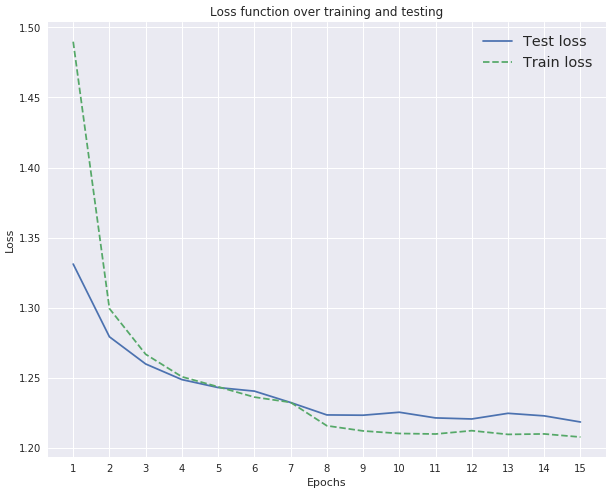

In [41]:
with plt.style.context(('seaborn')):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(loss_hist['test'], label='Test loss')
    ax.plot(loss_hist['train'], '--', label='Train loss')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    # ax.grid()
    plt.xticks(np.arange(0, len(loss_hist['train'])), labels=np.arange(1, len(loss_hist['train'])+1))
    plt.title('Loss function over training and testing')
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    plt.savefig('report/hector/finetunning/resnet18_loss.png', dpi=150)

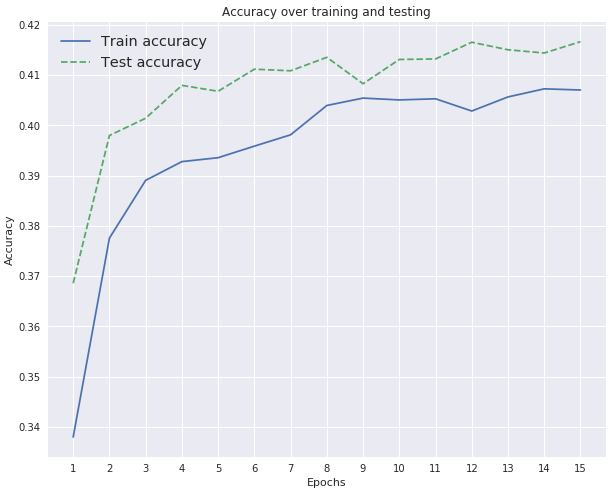

In [42]:
with plt.style.context(('seaborn')):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(acc_hist['train'], label='Train accuracy')
    ax.plot(acc_hist['test'], '--', label='Test accuracy')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    plt.xticks(np.arange(0, len(acc_hist['train'])), labels=np.arange(1, len(acc_hist['train'])+1))
    plt.title('Accuracy over training and testing')
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    plt.savefig('report/hector/finetunning/resnet18_acc.png', dpi=150)

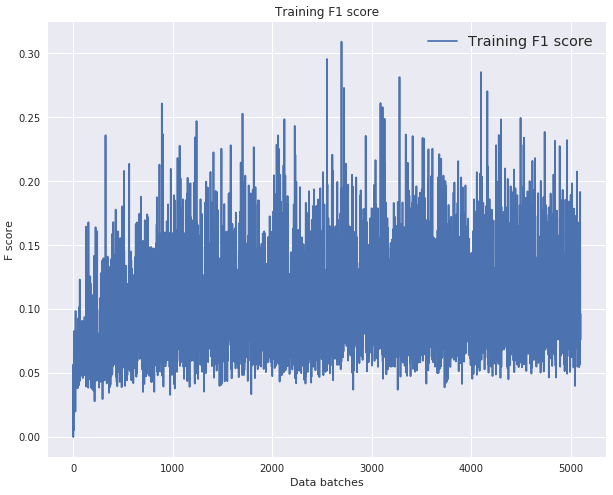

In [43]:
with plt.style.context(('seaborn')):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(f_score['train'], label='Training F1 score')
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('Data batches')
    ax.set_ylabel('F score')
    # plt.xticks(np.arange(0, len(f_score['train'])), labels=np.arange(1, len(f_score['train'])+1))
    plt.title('Training F1 score')
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    plt.savefig('report/hector/finetunning/resnet18_trainf1.png', dpi=150)

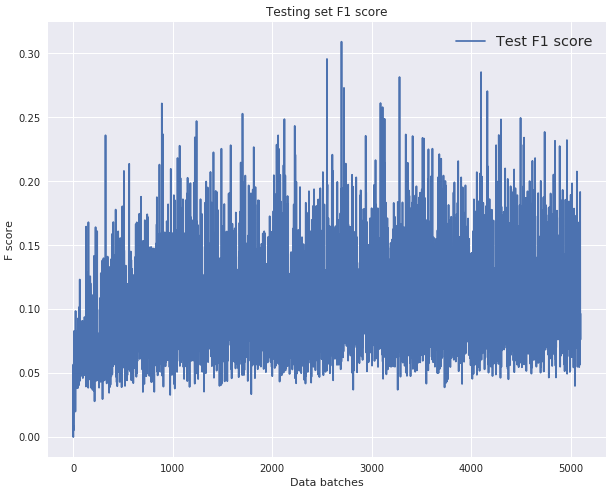

In [44]:
with plt.style.context(('seaborn')):
    fig, ax = plt.subplots(figsize=(10,8))
    ax.plot(f_score['train'], label='Test F1 score')
    # ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_xlabel('Data batches')
    ax.set_ylabel('F score')
    # plt.xticks(np.arange(0, len(f_score['train'])), labels=np.arange(1, len(f_score['train'])+1))
    plt.title('Testing set F1 score')
    legend = ax.legend(loc='best', shadow=True, fontsize='x-large')
    plt.savefig('report/hector/finetunning/resnet18_testf1.png', dpi=150)